In [2]:
from gensim import corpora,  models
from gensim.models import CoherenceModel
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from propiostopwords import stopWords

from nltk.stem import WordNetLemmatizer
from string import punctuation
import emoji
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy

In [5]:
nombreHashtag="#facebook"
nombreArchivo="#facebookFiltrado.csv"
lenguajeStopword=stopwords.words('english')
#lenguajeStopword=stopWords()

tweets=pd.read_csv(nombreArchivo,lineterminator='\n')
tweets.head()

,id,tweet,username,date,language
0,1457038850673426433,"TOP 10 MOST LIKED VIDEOS ON TIKTOK, IF YOU WAN...",khyaal547,2021-11-06,en
1,1457038717630177280,With #Facebook #META. $Mana will be the consta...,manadecentrland,2021-11-06,en
2,1457038685359247364,@StephenPunwasi Is anyone really surprised. #F...,mr62inontario,2021-11-06,en
3,1457038412012265484,One of the few things #Facebook does right is ...,warnekereading,2021-11-06,en
4,1457038405376819205,#businessgrowth #tumblr #twitter #facebook #in...,bmurphypointman,2021-11-06,en


In [6]:
corpus=tweets['tweet'].to_list()
#palabrasEvitar=['amp','covid','0','1','2','3','4','5','6','7','8','9']
palabrasEvitar=['rt', 'via', 'amp', 'http', 'https', 'm', 're', 'co',nombreHashtag,nombreHashtag[1:]]
list_punctuation=list(punctuation)+['¿','¡']
list_punctuation.remove('@')
#list_punctuation.remove('#')
listaStopwords=lenguajeStopword+palabrasEvitar
lemmatizer = WordNetLemmatizer()
nlp = spacy.load('es_core_news_sm')
#minusculas
corpus=[ str(document).lower() for document in corpus]

#urls
corpus=[re.sub('http[s]?://\S+', '', word) for word in corpus]

#emojis
corpus=[emoji.get_emoji_regexp().sub(u'', word) for word in corpus]

#punctuacion
corpus=[word.translate(str.maketrans('','', ''.join(list_punctuation))) for word in corpus]
#numeros y 
corpus=[re.sub('[0-9]+', '', word) for word in corpus if len(word) ]

#tokenizar y lemmatizar
texts=[[lemmatizer.lemmatize(word) for word in str(document).split() if word not in listaStopwords] for document in corpus]
#texts=[[nlp(word) for word in str(document).split() if word not in listaStopwords] for document in corpus]
#texts=[[nlp(document) ] for document in corpus]

print(texts[0:5])

[['top', 'liked', 'video', 'tiktok', 'want', 'check', 'tiktok', 'viral', 'earn', 'writer', 'liked', 'view', 'video', 'funny', 'million', 'profile', 'feed', 'home', 'srk', 'ronaldo', 'messi', 'twitter', 'life', 'live', 'dollar', 'work', 'job', 'business'], ['meta', 'mana', 'constant', 'companion', 'decentraland', 'project', 'expecting', 'price', 'reach', 'k', 'usdt'], ['@stephenpunwasi', 'anyone', 'really', 'surprised', 'large', 'corporation', 'law', 'need', 'major', 'overhaul'], ['one', 'thing', 'right', 'assaulting', 'memory', 'cute', 'word', 'baby', 'got', 'yr', 'ago', 'today', 'dogggo', 'puppy'], ['businessgrowth', 'tumblr', 'twitter', 'instagram', 'discount', 'socialmedia', 'blackfriday', 'pinterest', 'deal', 'gift', 'gift', 'giftideas', 'shop', 'shopping', 'affiliatemarketing', 'cybermonday', 'new', 'product', 'amazon', 'brand']]


LDA

In [7]:
dictionary=corpora.Dictionary(texts)
corpus=[dictionary.doc2bow(text) for text in texts]
print(dictionary)

Dictionary(27486 unique tokens: ['business', 'check', 'dollar', 'earn', 'feed']...)


In [8]:
coherence_values=[]
model_list=[]
for num_topics in range(2,11,1):
    model=lda=models.LdaModel(corpus,id2word=dictionary,num_topics=num_topics, random_state=100 ,alpha='auto', eval_every=5)
    model_list.append(model)
    coherencemodel=CoherenceModel(model=model, texts=texts,dictionary=dictionary,coherence='c_v')
    print(coherencemodel.get_coherence())
    coherence_values.append(coherencemodel.get_coherence())

0.5470646967481994
0.6648226818721404
0.6056228363841725
0.539921615490417
0.5820855160058966
0.5607099264284353
0.5860214871495865
0.5314362119928558
0.5911607043686459


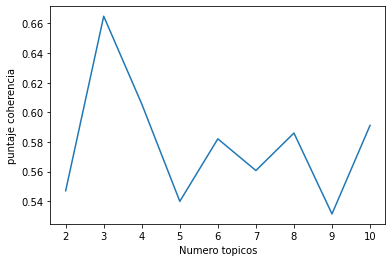

In [9]:
x=range(2,11,1)
plt.plot(x,coherence_values)
plt.xlabel("Numero topicos")
plt.ylabel("puntaje coherencia")
plt.show()

In [10]:
topicos_dictionary=dict(zip(x,coherence_values))
max_coherence=max(topicos_dictionary,key=topicos_dictionary.get)
cantidadTopicos=max_coherence

lda=models.LdaModel(corpus,id2word=dictionary,num_topics=cantidadTopicos, random_state=100 ,alpha='auto', eval_every=5)
lda.show_topics(cantidadTopicos,3)

[(0, '0.018*"meta" + 0.013*"metaverse" + 0.007*"like"'),
 (1, '0.097*"gift" + 0.056*"deal" + 0.052*"affiliatemarketing"'),
 (2, '0.046*"gift" + 0.038*"deal" + 0.036*"instagram"')]

Wordcloud

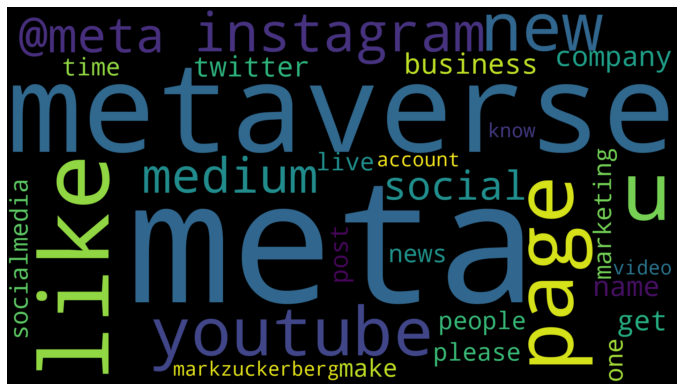

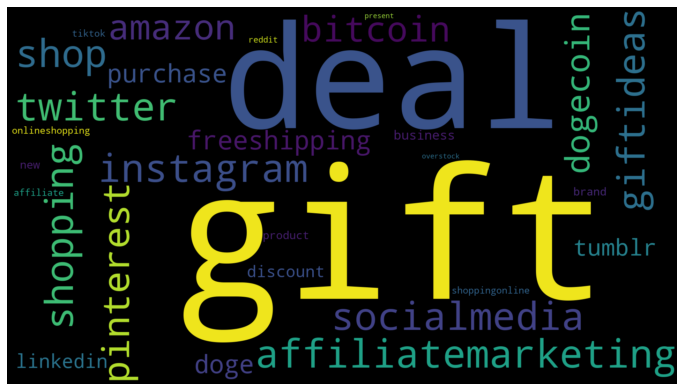

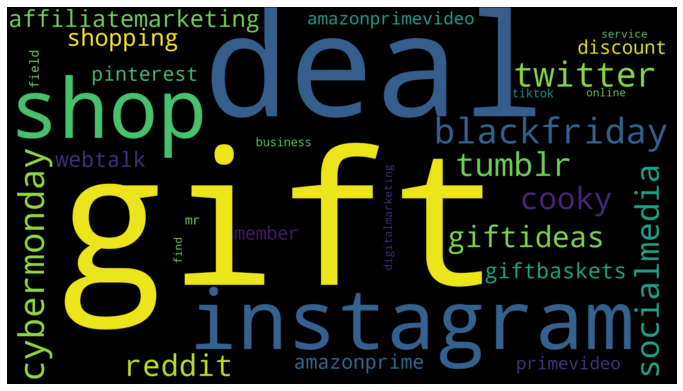

In [11]:
curr_topic = 0
for l in lda.print_topics(cantidadTopicos,num_words=30):
    line = l[1]
    scores = [float(x.split("*")[0]) for x in line.split(" + ")]
    words = [re.sub('\"', '', x.split("*")[1]) for x in line.split(" + ")]
    freqs = []

    freqs=dict(zip(words, scores))
    elements = WordCloud(width=1920, height=1080).generate_from_frequencies(freqs)


    plt.rcParams['figure.figsize'] = 12, 8
    plt.imshow(elements, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    curr_topic += 1

In [12]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(lda, corpus, dictionary)
lda_viz

/home/oem/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/home/oem/.local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/oem/.local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/oem/.local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/oem/.local/lib/python3.8/site-packages/past/builtins/misc.py:45: Deprecation

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.341075 -0.028737       1        1  50.853150
1     -0.233125 -0.103086       2        1  39.529014
2     -0.107950  0.131823       3        1   9.617835, topic_info=                    Term          Freq         Total Category  logprob  \
68                  gift  18182.000000  18182.000000  Default  30.0000   
66                  deal  11026.000000  11026.000000  Default  29.0000   
74                  shop   9936.000000   9936.000000  Default  28.0000   
60    affiliatemarketing   9669.000000   9669.000000  Default  27.0000   
75              shopping   9446.000000   9446.000000  Default  26.0000   
...                  ...           ...           ...      ...      ...   
609     digitalmarketing    154.272490    368.243577   Topic3  -5.5819   
3397               party    148.720766    373.330937   Topic3  -5.6186   
16                tiktok    193.820151   1213.893062   Topic3  -5.3537   
0               business    216.620289   2363.928995   Topic3  -5.2425   
546               online    149.471219    692.147857   Topic3  -5.6135   

      loglift  
68    30.0000  
66    29.0000  
74    28.0000  
60    27.0000  
75    26.0000  
...       ...  
609    1.4715  
3397   1.4212  
16     0.5069  
0     -0.0484  
546    0.8089  

[194 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
177       1  0.998719       @meta
177       2  0.001049       @meta
384       1  0.997148     account
384       2  0.001734     account
85        1  0.995027          ad
...     ...       ...         ...
197       1  0.887106     youtube
197       2  0.003280     youtube
197       3  0.109863     youtube
718       1  0.998034  zuckerberg
718       2  0.001782  zuckerberg

[292 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])